In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame as df
import seaborn as sns

from keras.models import load_model


from keras.layers import LSTM, Dense
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split

In [72]:
LR = glob.glob('C:/Users/hlee185/OneDrive - Georgia State University/2021 Fall/IoT/Dataset/LR_100/*.csv')
RL = glob.glob('C:/Users/hlee185/OneDrive - Georgia State University/2021 Fall/IoT/Dataset/RL_100/*.csv')
UP = glob.glob('C:/Users/hlee185/OneDrive - Georgia State University/2021 Fall/IoT/Dataset/UP_100/*.csv')
Down = glob.glob('C:/Users/hlee185/OneDrive - Georgia State University/2021 Fall/IoT/Dataset/Down_100/*.csv')

len(LR), len(RL), len(UP), len(Down)

(100, 100, 100, 100)

In [73]:
total_data = LR + RL + UP + Down

dataset = np.zeros((len(total_data), 100, 4))

dataset

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

In [74]:
for i, data in enumerate(total_data):
    dataset[i] = pd.read_csv(data, names=['n','a','b','c','d']).sample(n=100).sort_index().iloc[:,1:5]

In [84]:
dataset = pd.read_csv(data, names=['n','a','b','c','d']).sample(n=100).sort_index().iloc[:,1:5]
dataset = np.array(dataset)
dataset

array([[ 1.852,  3.374,  0.07 ,  1.154],
       [ 0.148,  3.374,  0.07 ,  0.154],
       [ 0.852,  3.374,  0.93 ,  0.154],
       [ 0.852,  2.374,  0.93 ,  0.154],
       [ 1.148,  1.374,  2.93 ,  1.154],
       [ 1.148,  1.374,  2.93 ,  1.154],
       [ 1.148,  0.374,  1.93 ,  1.154],
       [ 2.148,  0.374,  1.93 ,  1.154],
       [ 1.148,  0.374,  1.93 ,  1.154],
       [ 2.148,  0.374,  0.93 ,  0.154],
       [ 2.148,  0.374,  0.93 ,  0.154],
       [ 1.148,  0.374,  0.93 ,  0.154],
       [ 1.148,  0.374,  0.93 ,  0.154],
       [ 1.148,  0.626,  0.07 ,  0.154],
       [ 0.148,  0.626,  0.07 ,  0.154],
       [ 0.148,  0.626,  0.07 ,  0.154],
       [ 0.148,  0.626,  0.07 ,  0.154],
       [ 1.148,  0.374,  1.07 ,  0.154],
       [ 1.148,  0.374,  1.07 ,  0.846],
       [ 0.148,  1.374,  0.07 ,  0.846],
       [ 0.148,  1.374,  1.07 ,  0.846],
       [ 0.148,  1.374,  0.07 ,  0.846],
       [ 0.148,  2.374,  0.07 ,  0.154],
       [ 1.148,  1.374,  0.07 ,  0.154],
       [ 0.148, 

([<matplotlib.lines.Line2D at 0x21ed83ca430>,
 400)

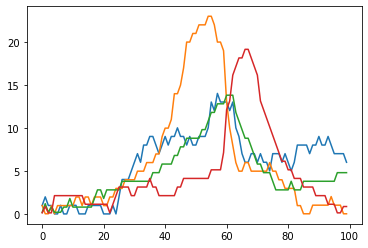

In [75]:
plt.plot(dataset[0]), len(dataset)

In [76]:
label = np.array([[1, 0, 0, 0]] * len(LR) + [[0, 1, 0 ,0]] * len(RL) + [[0, 0, 1, 0]] * len(UP) + [[0, 0, 0, 1]] * len(Down))
dataset.shape, label.shape

((400, 100, 4), (400, 4))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, random_state=0, test_size=0.3)

X_test.shape

(120, 100, 4)

(100, 4)

In [11]:
callback = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001), 
    ModelCheckpoint(filepath='./weights.h5', save_best_only=True),
    EarlyStopping(monitor='val_acc', restore_best_weights=True, patience=5)
]

In [23]:
K.clear_session()

In [24]:
model_once = Sequential()

model_once.add(LSTM(20, input_shape=(100,4)))
model_once.add(Dense(64,activation='relu')) #tanh
model_once.add(Dense(16,activation='relu')) #tanh
model_once.add(Dense(4, activation='softmax'))
model_once.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['acc'])

model_once.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                2000      
_________________________________________________________________
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 4,452
Trainable params: 4,452
Non-trainable params: 0
_________________________________________________________________


In [25]:
#result = model_once.fit(X_train, y_train, validation_split=0.33, epochs=30, batch_size=10, verbose=0)
result = model_once.fit(X_train, y_train, epochs=30)

Epoch 1/30
9/9 [==============================] - 1s 16ms/step - loss: 1.4090 - acc: 0.2036
Epoch 2/30
9/9 [==============================] - 0s 14ms/step - loss: 1.3813 - acc: 0.2643
Epoch 3/30
9/9 [==============================] - 0s 14ms/step - loss: 1.3704 - acc: 0.3321
Epoch 4/30
9/9 [==============================] - 0s 16ms/step - loss: 1.3462 - acc: 0.3643
Epoch 5/30
9/9 [==============================] - 0s 13ms/step - loss: 1.2916 - acc: 0.4143
Epoch 6/30
9/9 [==============================] - 0s 14ms/step - loss: 1.2477 - acc: 0.4214
Epoch 7/30
9/9 [==============================] - 0s 16ms/step - loss: 1.0254 - acc: 0.6036
Epoch 8/30
9/9 [==============================] - 0s 16ms/step - loss: 0.8291 - acc: 0.6500
Epoch 9/30
9/9 [==============================] - 0s 14ms/step - loss: 0.6264 - acc: 0.7286
Epoch 10/30
9/9 [==============================] - 0s 14ms/step - loss: 0.4036 - acc: 0.8571
Epoch 11/30
9/9 [==============================] - 0s 14ms/step - loss: 0.2928 

In [26]:
model_once.save('LSTM model.h5')
model_once.evaluate(X_test, y_test)

4/4 [==============================] - 0s 8ms/step - loss: 0.0782 - acc: 0.9833


[0.07815558463335037, 0.9833333492279053]

In [67]:
a = np.arange(1,9)
b = a.reshape(1,2,4)
b.shape

(1, 2, 4)

In [68]:
s = X_test[0].reshape(1,100,4)
s.shape

(1, 100, 4)

In [71]:
ans = model_once.predict(s) 
axss=np.argmax(ans,axis=1)
axss

array([1], dtype=int64)

In [49]:
predict_x=model_once.predict(X_test) 
classes_x_test=np.argmax(predict_x,axis=1)

classes_x_test

array([1, 3, 3, 1, 2, 0, 1, 2, 1, 2, 0, 1, 1, 3, 0, 0, 2, 1, 2, 1, 1, 2,
       1, 3, 1, 3, 1, 0, 2, 1, 1, 3, 3, 2, 0, 0, 0, 1, 1, 3, 1, 3, 0, 0,
       2, 0, 3, 2, 1, 2, 2, 1, 2, 1, 2, 3, 0, 0, 0, 0, 0, 2, 0, 3, 1, 3,
       1, 2, 1, 3, 0, 2, 0, 0, 1, 0, 3, 3, 3, 3, 3, 0, 0, 1, 3, 2, 1, 3,
       3, 3, 3, 2, 0, 0, 1, 1, 1, 3, 2, 3, 2, 0, 3, 1, 2, 3, 0, 3, 1, 2,
       0, 0, 2, 0, 3, 2, 2, 0, 2, 3], dtype=int64)

In [50]:
classes_y_test = []
for i in range(len(y_test)):
    for j in range(4):
        if y_test[i][j] == 1:
            classes_y_test.append(j)


In [51]:
count=0
print("Real value : Prediction\n---------------------------")
for i in range(len(X_test)):
    if(classes_x_test[i] != classes_y_test[i]):
        print("   ",classes_y_test[i], "\t   : \t", classes_x_test[i])
        count = count + 1
probab = count/len(X_test)
print("\n\nNumber of miscalculation : ",count,"/",len(x_test_to_int),"=",round(probab,3))
print("\nAccuracy : ",((1-round(probab,4))*100),"%")
print("0 : LR, 1 : RL, 3 : UP, 4 : DOWN")

Real value : Prediction
---------------------------
    0 	   : 	 1
    0 	   : 	 2


Number of miscalculation :  2 / 120 = 0.017

Accuracy :  98.33 %
0 : LR, 1 : RL, 3 : UP, 4 : DOWN
